# Split head and body(clothes) in masks

* Visit [face_segmentation_keras](https://github.com/shaoanlu/face-segmentation-keras) and download [Keras_FCN8s_face_seg_YuvalNirkin.h5](https://drive.google.com/open?id=1alyR6uv4CHt1WhykiQIiK5MZir7HSOUU)
* Need to install [maskrcnn_benchmark](https://github.com/facebookresearch/maskrcnn-benchmark)  

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
# FaceModel must be imported before COCODemo, otherwise
# there will be a serious conflict leading to kernel restart
from face_fcn8 import FaceModel
from maskrcnn_benchmark.config import cfg
from rcnn import COCODemo as PersonModel

/home/liuqixuan/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/liuqixuan/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Set GPU limit for Keras

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Select which GPU to use
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth = True  # Do not allocate all GPU memories
session = tf.Session(config=tfconfig)
KTF.set_session(session)

## Parameters

In [3]:
image_path = "./images/000000009179.jpg"
rcnn_cfg = "./rcnn_configs/caffe2/e2e_mask_rcnn_X-152-32x8d-FPN-IN5k_1.44x_caffe2.yaml"
face_weight = "Keras_FCN8s_face_seg_YuvalNirkin.h5"
# Size of the morphological kernel, the larger the value, the greater the range of filters
noisy_filter_size = 20
line_color = [255, 255, 0]
line_thickness = 5
body_color = [255, 20, 127]
head_color = [0, 23, 232]
mask_alpha = 0.75

## Instantiate Models
body_model must be instantiated before face_model, otherwise 
there may be a serious conflict leading to kernel restart

In [4]:
cfg.merge_from_file(rcnn_cfg)
cfg.freeze()
person_model = PersonModel(
    cfg,
    confidence_threshold=0.7,
    show_mask_heatmaps=True,
    masks_per_dim=2,
    min_image_size=224,
)

In [5]:
face_model = FaceModel()
face_model.load_weights(face_weight)

## Import Image

Image size is  (427, 640, 3)


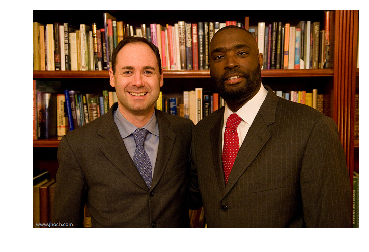

In [6]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# visualize
plt.axis('off')
plt.imshow(image)
print("Image size is ", image.shape)

## Draw Person Mask

In [7]:
# get person mask
predictions = person_model.compute_prediction(image)
predictions = person_model.select_top_predictions(predictions)
masks = predictions.get_field("mask").numpy()
labels = predictions.get_field("labels")
bboxes = predictions.bbox
print("%d object(s) detected." % len(labels))

7 object(s) detected.


Stored 2 person(s) into list


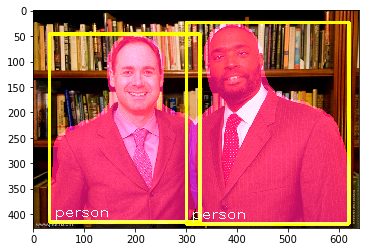

In [8]:
persons = []  # [offset, person_img, person_mask]
canvas1 = np.zeros_like(image)  # apply alpha
canvas2 = image.copy()  # not apply alpha
for mask, label, bbox in zip(masks, labels, bboxes):
    if label == 1:
        mask = mask[0, :, :, np.newaxis]
        _, thresh = cv2.threshold(mask, mask.mean(), 255, cv2.THRESH_BINARY)
        x1, y1, x2, y2 = bbox.numpy().astype(np.int32)
        person_img = image[y1:y2 + 1, x1:x2 + 1]
        person_mask = thresh[y1:y2 + 1, x1:x2 + 1]
        persons.append([(x1, y1), person_img, person_mask])
        # visualize
        blank = np.zeros_like(canvas1, np.uint8)
        blank[:] = body_color
        canvas1 = cv2.add(canvas1, cv2.bitwise_or(blank, blank, mask=thresh))
        cv2.rectangle(canvas2, (x1, y1), (x2, y2), line_color, line_thickness)
        cv2.putText(canvas2, person_model.CATEGORIES[label],
                    (x1 + 2 * line_thickness, y2 - 2 * line_thickness),
                    cv2.FONT_HERSHEY_DUPLEX, 1, [255, 255, 255])
canvas2 = cv2.scaleAdd(canvas1, mask_alpha, canvas2)
plt.figure()
plt.imshow(canvas2)
print("Stored %d person(s) into list" % len(persons))

## Draw Face Mask

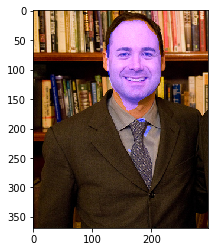

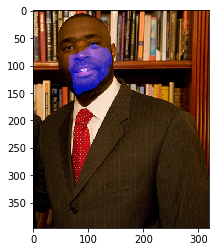

In [9]:
def get_face_mask(img, face_model):
    im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = im.shape[0], im.shape[1]
    im = cv2.resize(im, (500, 500))
    im = np.array(im, dtype=np.float32)
    im = im[:, :, ::-1]
    im -= np.array((104.00698793, 116.66876762, 122.67891434))
    im = im[np.newaxis, :]
    #im = im.transpose((2,0,1))
    mask = face_model.predict([im])[0]
    mask = cv2.resize(mask, (w, h)).argmax(axis=-1).astype(np.uint8)
    _, thresh = cv2.threshold(mask[:, :, np.newaxis], mask.mean(), 255,
                              cv2.THRESH_BINARY)
    return thresh


for i, person in enumerate(persons):
    offset, person_img, person_mask = person
    h, w = person_mask.shape
    in_img = person_img[:w]
    face_mask = get_face_mask(in_img, face_model)
    if h > w:
        face_mask = np.concatenate([face_mask, np.zeros((h - w, w), np.uint8)])
    person.append(face_mask) # Now persons' elements are [offset, cropped_img, body_mask, face_mask]
    # visualize
    canvas = np.zeros_like(person_img)
    canvas[:] = head_color
    canvas = cv2.bitwise_or(canvas, canvas, mask=face_mask)
    canvas = cv2.scaleAdd(canvas, mask_alpha, person_img)
    plt.figure()
    plt.imshow(canvas)

## Mask Operations

* Take the intersection for _Head_
* Take the difference set for _Body_

In [10]:
def morph_open(mask, kernel_size=5):
    """Removing noise by morphological opening operation (erosion followed by dilation)"""
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)


def bbox(mask):
    """Find the bounding box of a mask"""
    axis0 = np.any(mask, axis=0)
    axis1 = np.any(mask, axis=1)
    x, u = np.where(axis0)[0][[0, -1]]
    y, v = np.where(axis1)[0][[0, -1]]
    return (x, y), (u, v)

[0]BBox is from (126, 19) to (216, 164), areas to be filled are (x, 0) to (171,64) and (171, 0) to (216, 77)
[1]BBox is from (67, 67) to (141, 147), areas to be filled are (x, 0) to (104,83) and (104, 0) to (141, 79)


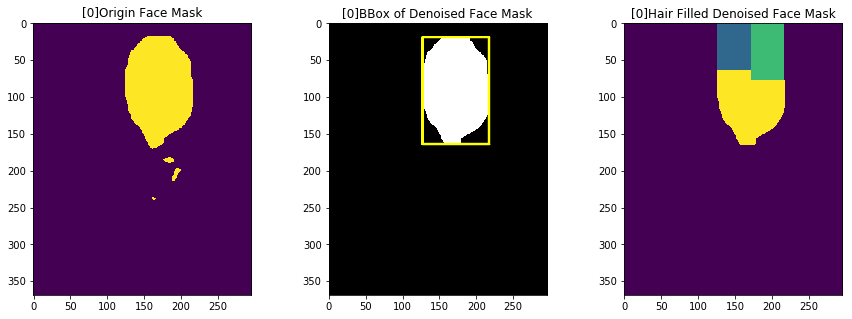

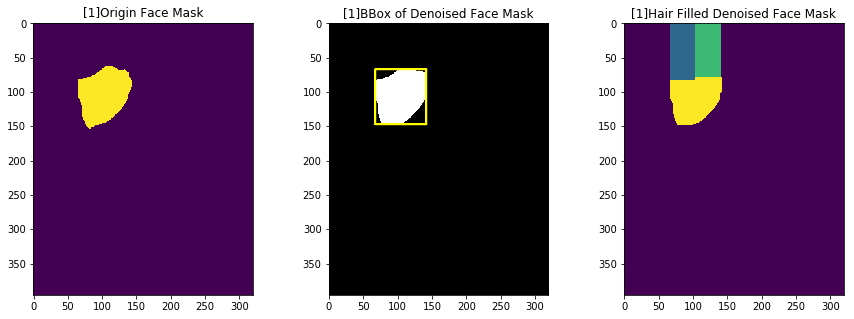

In [11]:
for i, (offset, person_img, person_mask, face_mask) in enumerate(persons):
    denoised_mask = morph_open(face_mask, noisy_filter_size)
    assert denoised_mask.any(), \
        "No face can be found from {} to {}, may be you can try to decrease noisy_filter_size".format(
            offset, face_mask.shape)
    (x, y), (u, v) = bbox(denoised_mask)
    h, w = denoised_mask.shape
    left_y = np.where(denoised_mask[:, x])[0][0]
    right_y = np.where(denoised_mask[:, u])[0][0]
    mid_x = (x + u) // 2
    persons[i] = [offset, person_img, person_mask, denoised_mask, x, mid_x, u, left_y, right_y]
    # visualize
    face_bbox = cv2.rectangle(denoised_mask[..., np.newaxis].repeat(3, -1),
                              (x, y), (u, v), line_color, 2, 16)
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    plt.subplot(131)
    plt.title("[{}]Origin Face Mask".format(i))
    plt.imshow(face_mask)
    plt.subplot(132)
    plt.title("[{}]BBox of Denoised Face Mask".format(i))
    plt.imshow(face_bbox)
    plt.subplot(133)
    plt.title("[{}]Hair Filled Denoised Face Mask".format(i))
    visual_mask = denoised_mask.copy()
    visual_mask[:left_y, x:mid_x] = 85
    visual_mask[:right_y, mid_x:u] = 175
    plt.imshow(visual_mask)
    msg = "[{}]BBox is from ({}, {}) to ({}, {})".format(i, x, y, u, v)
    msg += ", areas to be filled are (x, 0) to ({mx},{ly}) and ({mx}, 0) to ({u}, {ry})".format(
        x=x, mx=mid_x, u=u, ly=left_y, ry=right_y)
    print(msg)

Final head mask and body mask


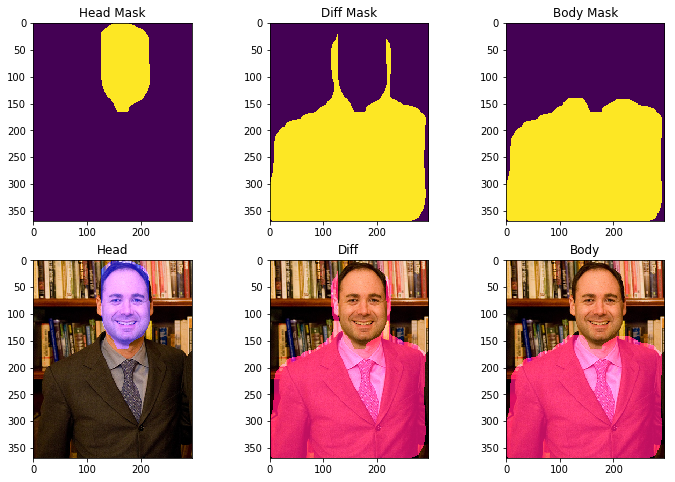

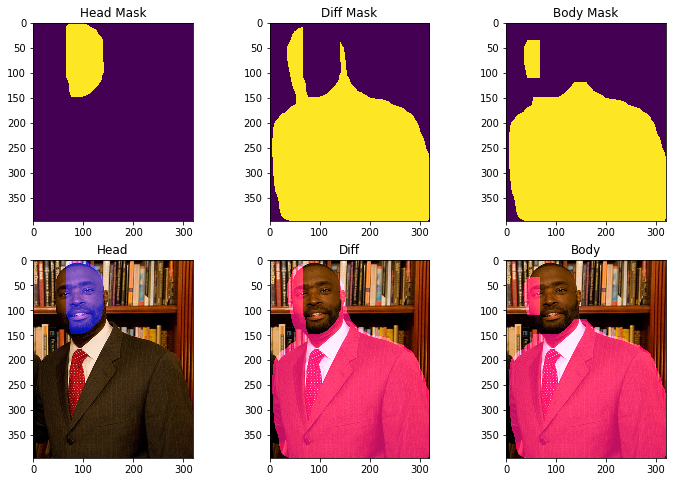

In [12]:
for offset, person_img, person_mask, denoised_mask, x, mid_x, u, left_y, right_y in persons:
    # Take the intersection for Head
    head_mask = denoised_mask.copy()
    head_mask[:left_y, x:mid_x] = 255
    head_mask[:right_y, mid_x:u] = 255
    head_mask = person_mask & head_mask
    # Take the difference set for Body
    diff_mask = person_mask & (~head_mask)
    body_mask = morph_open(diff_mask, int(1.3 * noisy_filter_size))

    # visualize
    fig = plt.figure()
    fig.set_size_inches(12, 8)

    plt.subplot(231)
    plt.title("Head Mask")
    plt.imshow(head_mask)

    plt.subplot(232)
    plt.title("Diff Mask")
    plt.imshow(diff_mask)

    plt.subplot(233)
    plt.title("Body Mask")
    plt.imshow(body_mask)

    blank = np.zeros_like(person_img)
    plt.subplot(234)
    plt.title("Head")
    blank[:] = head_color
    v_head = cv2.scaleAdd(cv2.bitwise_and(blank, blank, mask=head_mask),
                          mask_alpha, person_img.copy())
    plt.imshow(v_head)

    plt.subplot(235)
    plt.title("Diff")
    blank[:] = body_color
    v_diff = cv2.scaleAdd(cv2.bitwise_and(blank, blank, mask=diff_mask),
                          mask_alpha, person_img.copy())
    plt.imshow(v_diff)

    plt.subplot(236)
    plt.title("Body")
    blank[:] = body_color
    v_body = cv2.scaleAdd(cv2.bitwise_and(blank, blank, mask=body_mask),
                          mask_alpha, person_img.copy())
    plt.imshow(v_body)

print("Final head mask and body mask")